In [1]:
import os
os.chdir("../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import scanpy as sc
import numpy as np
import surgeon

Using TensorFlow backend.


In [5]:
sc.settings.set_figure_params(dpi=200)

In [6]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Pancreas CelSeq2", "Pancreas SS2"]
target_cell_types = ['Pancreas Alpha']

In [7]:
sc.settings.figdir = "./results/outofsample/pancreas_alpha/"

# Loading 5 Pancreas datasets and data preparation

In [8]:
adata = sc.read("./data/pancreas/pancreas_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 15681 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

## Number of cells in each batch

In [9]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8391
Pancreas SS2            2961
Pancreas CelSeq2        2426
Pancreas CelSeq         1271
Pancreas Fluidigm C1     632
Name: study, dtype: int64

## Now we leave out one study (SS2) for training the newtork

In [10]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 10294 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [11]:
adata_for_training = adata_for_training[~adata_for_training.obs[cell_type_key].isin(target_cell_types)]
adata_for_training

View of AnnData object with n_obs × n_vars = 7584 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [12]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 5387 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

## Train/Test Split

In [13]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.8)

In [14]:
train_adata.shape, valid_adata.shape

((6067, 1000), (1517, 1000))

In [15]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())
n_conditions

3

# Create & Train model with training data

In [16]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             architecture=[128, 64, 32],
                             n_conditions=n_conditions,
                             use_batchnorm=False,
                             lr=0.001,
                             alpha=0.0005,
                             beta=1000.0,
                             clip_value=100.0,
                             eta=1.0,
                             loss_fn='mse',
                             model_path=f"./models/OutOfSample/Pancreas/Before/",
                             dropout_rate=0.1,
                             output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 3)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 128)          128384      data[0][0]                       
                                                                 encoder_labels[0][0]             
_____________________

## We assign each study to a numerical label 

In [17]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Pancreas inDrop': 0, 'Pancreas CelSeq': 1, 'Pancreas Fluidigm C1': 2}

## Training the network

In [18]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              cell_type_key=cell_type_key,
              le=condition_encoder,
              n_epochs=10000,
              batch_size=1024, 
              early_stop_limit=50,
              lr_reducer=40, 
              n_per_epoch=0,
              save=True,
              retrain=True,
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 6067 samples, validate on 1517 samples
Epoch 1/10000
 - 4s - loss: 2518.2215 - reconstruction_loss: 2465.8290 - mmd_loss: 52.3926 - val_loss: 2365.9821 - val_reconstruction_loss: 2294.1760 - val_mmd_loss: 71.8061
Epoch 2/10000
 - 0s - loss: 2257.8268 - reconstruction_loss: 2210.8330 - mmd_loss: 46.9937 - val_loss: 2086.4808 - val_reconstruction_loss: 1992.1899 - val_mmd_loss: 94.2910
Epoch 3/10000
 - 0s - loss: 2043.4145 - reconstruction_loss: 1992.2321 - mmd_loss: 51.1824 - val_loss: 1950.7468 - val_reconstruction_loss: 1866.5715 - val_mmd_loss: 84.1753
Epoch 4/10000
 - 0s - loss: 1942.7711 - reconstruction_loss: 1898.2647 - mmd_loss: 44.5065 - val_loss: 1866.9968 - val_reconstruction_loss: 1793.2092 - val_mmd_loss: 73.7875
Epoch 5/10000
 - 0s - loss: 1868.7460 - reconstruction_loss: 1823.9028 - mmd_loss: 44.8432 - val_loss: 1787.2253 - val_reconstruction_loss: 1695.5617 - val_mmd_loss: 91.6636
Epoch 6/10000
 - 0s - loss: 1764.7

In [19]:
network.condition_encoder

{'Pancreas inDrop': 0, 'Pancreas CelSeq': 1, 'Pancreas Fluidigm C1': 2}

In [20]:
encoder_labels, _ = surgeon.utils.label_encoder(
    adata_for_training, label_encoder=network.condition_encoder, condition_key=condition_key)

In [21]:
latent_adata = network.to_mmd_layer(adata_for_training, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 7584 × 32 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [22]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [23]:
latent_adata.uns[f"{condition_key}_colors"] = sc.pl.palettes.zeileis_28[:2]

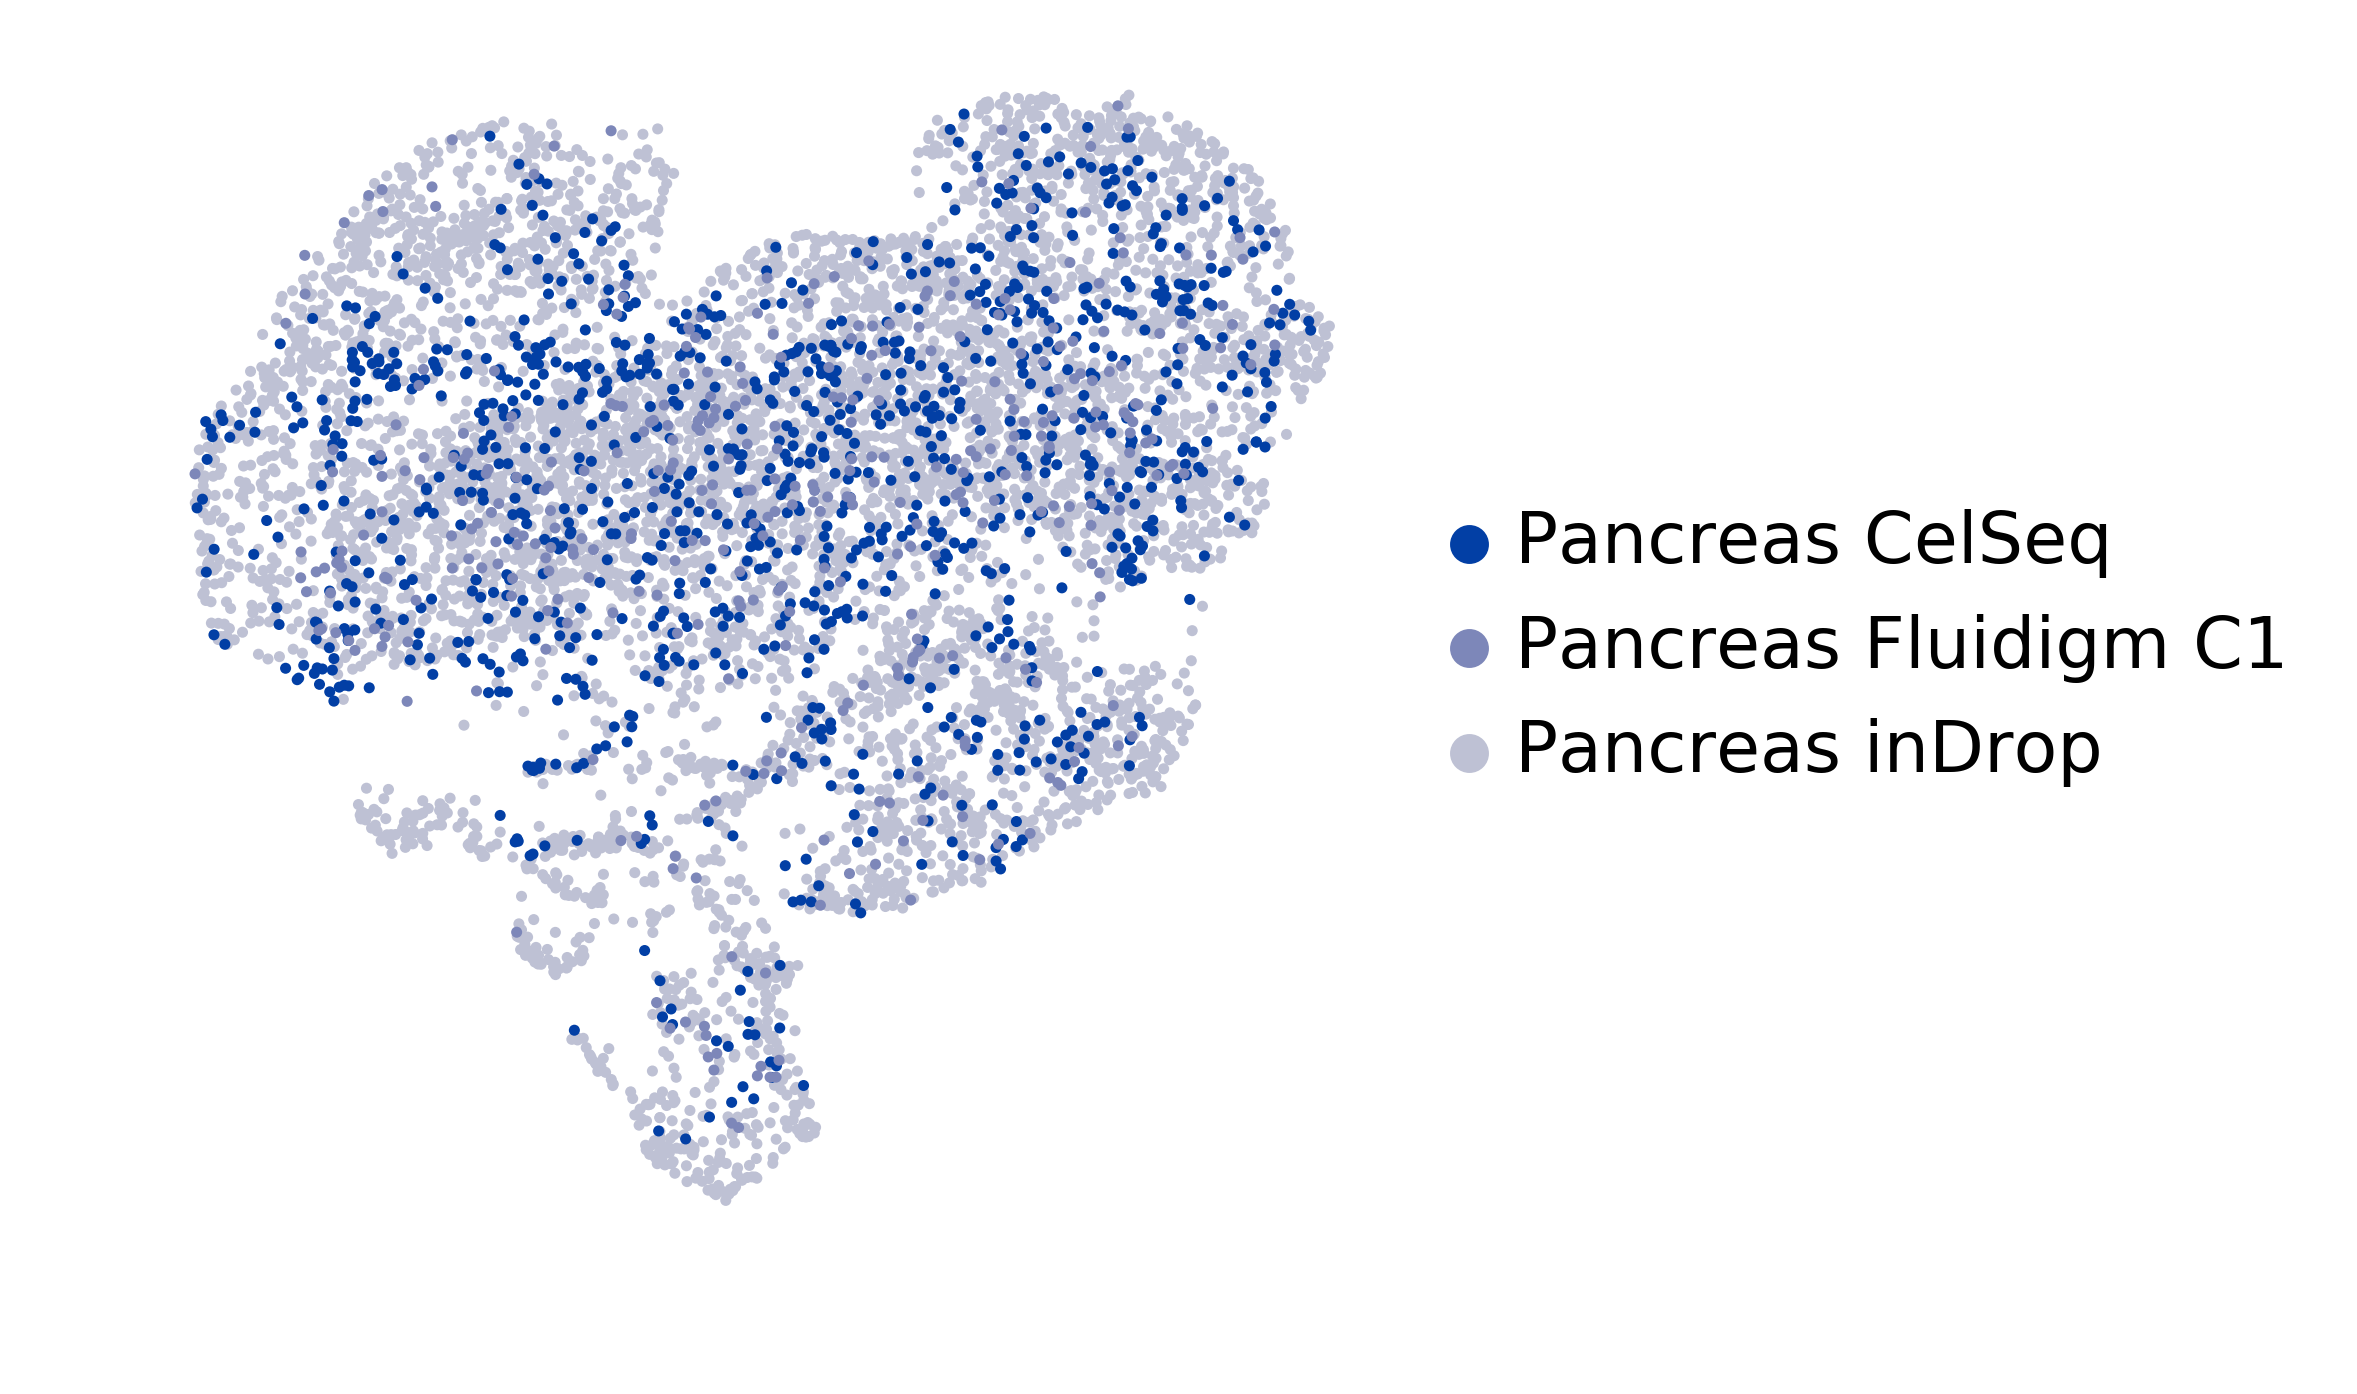

In [24]:
sc.pl.umap(latent_adata, color=[condition_key], frameon=False, title="", 
           save="_condition_before.pdf", palette=sc.pl.palettes.zeileis_28)

In [25]:
palette = sc.pl.palettes.godsnot_102[:1] + sc.pl.palettes.godsnot_102[2:]

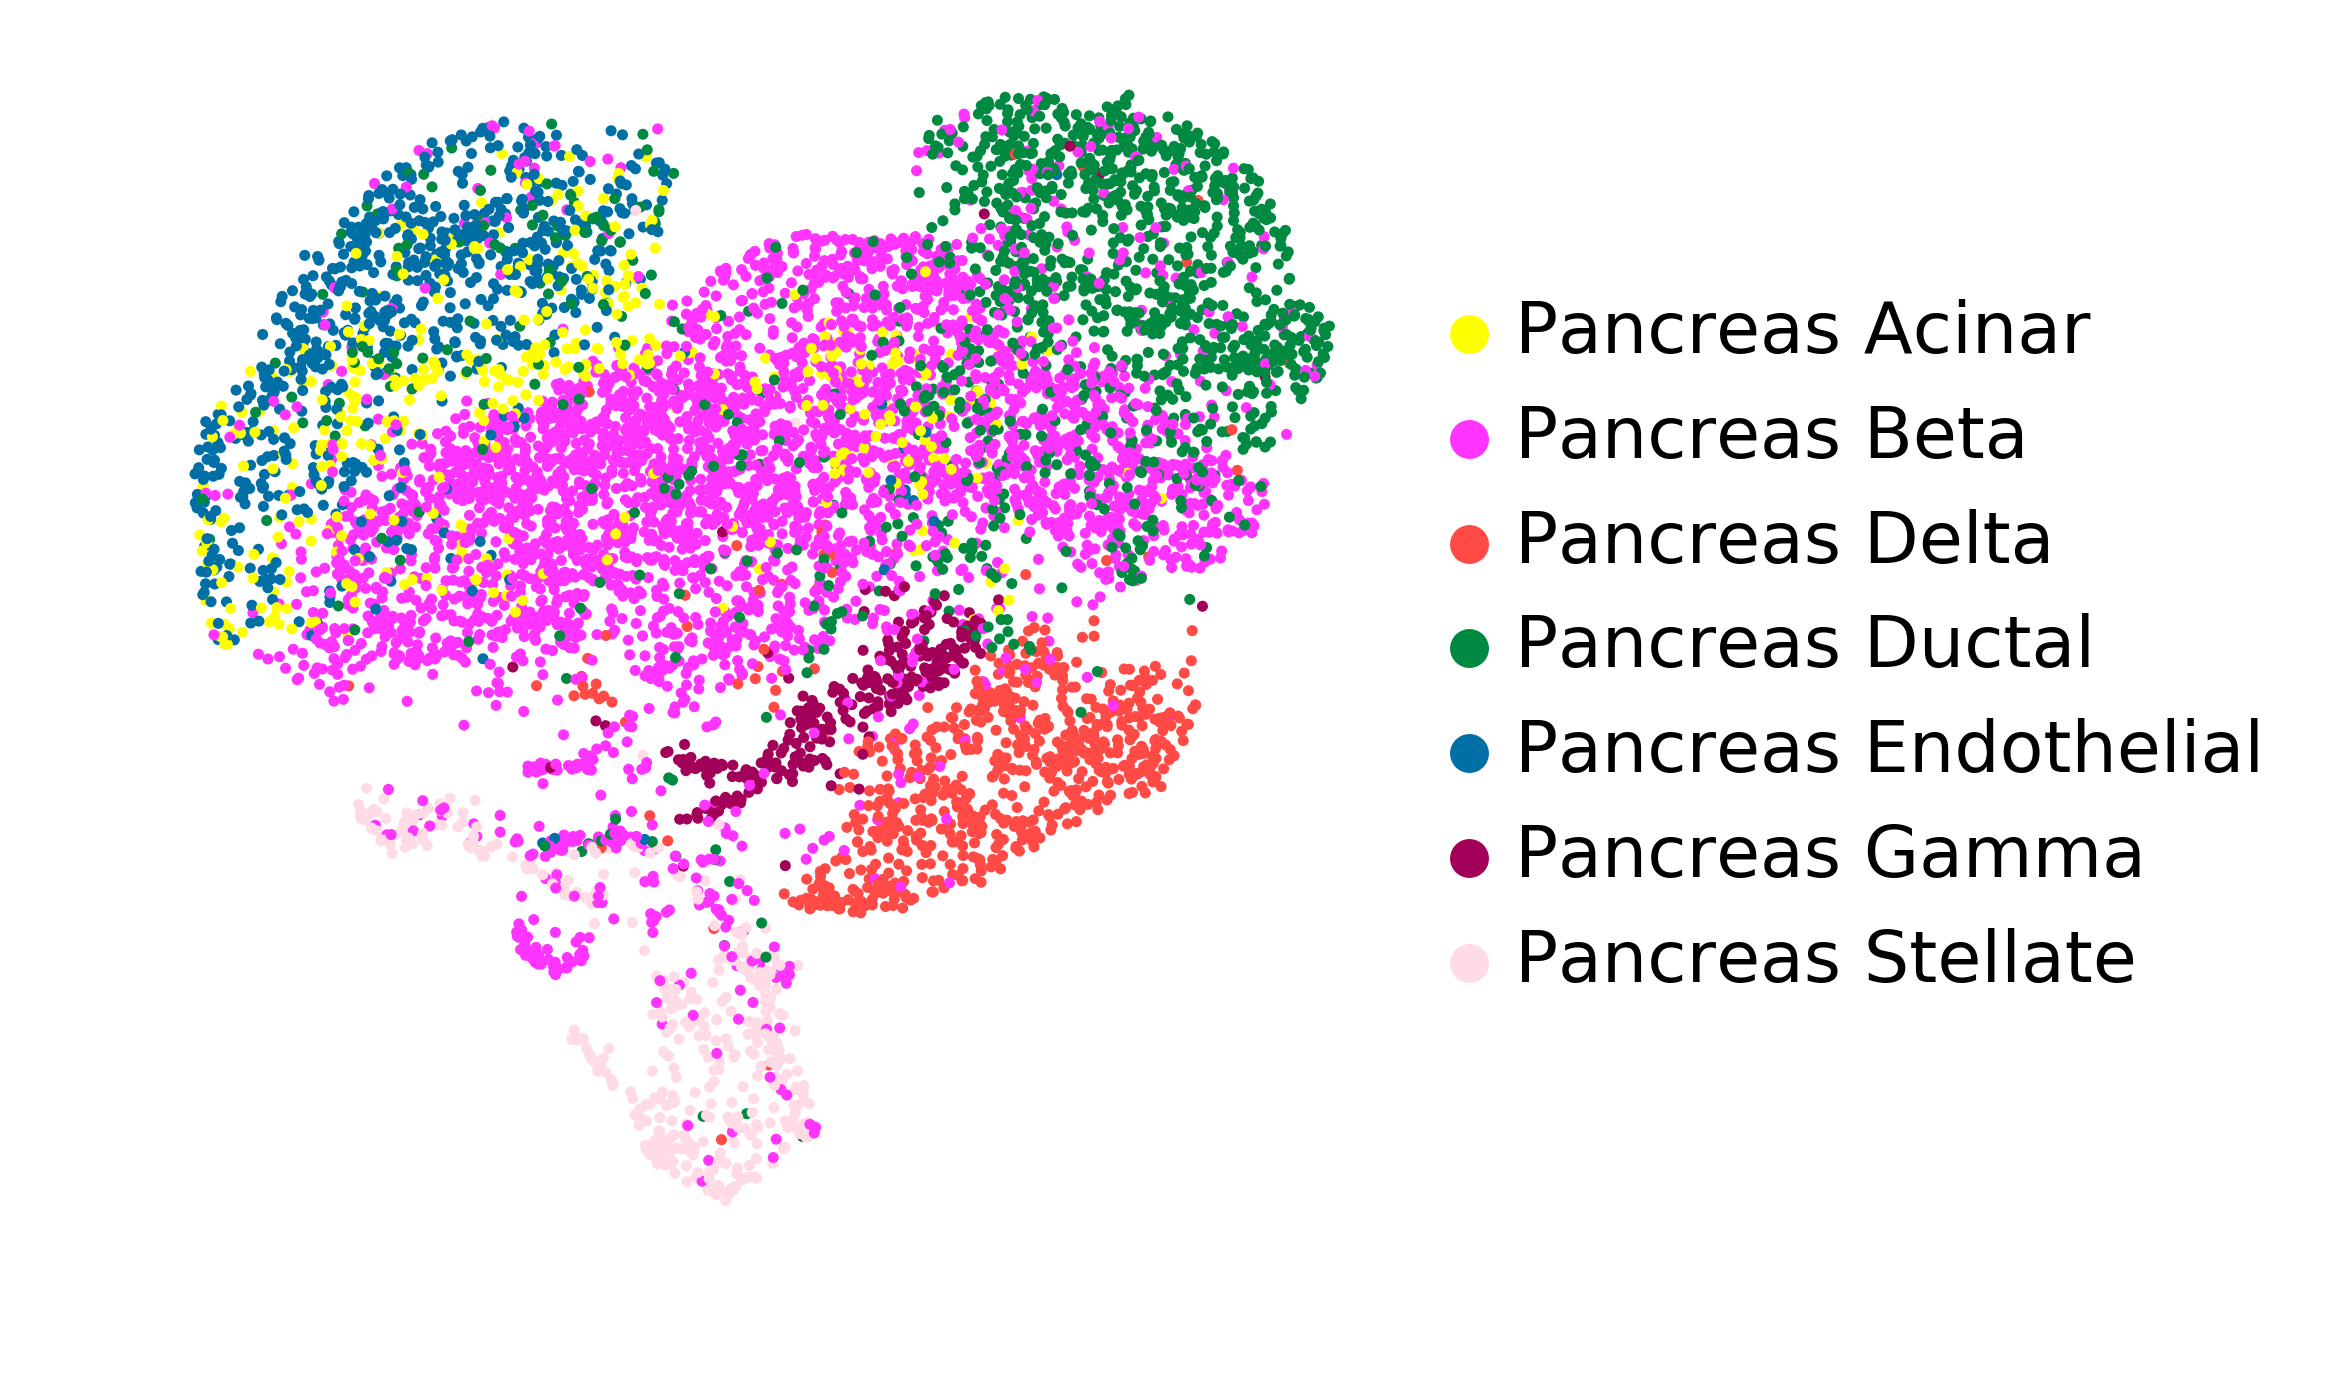

In [26]:
sc.pl.umap(latent_adata, color=[cell_type_key], frameon=False, title="", 
           save="_cell_type_before.pdf", palette=palette)

# Perfroming architecture Surgery

In [27]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              init='Xavier',
                              freeze_expression_input=True,
                              freeze=True,
                              )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 5)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 128)          128640      data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 128)          0           first_layer[0][0]                
__________

In [28]:
new_network.condition_encoder

{'Pancreas inDrop': 0,
 'Pancreas CelSeq': 1,
 'Pancreas Fluidigm C1': 2,
 'Pancreas CelSeq2': 3,
 'Pancreas SS2': 4}

## Train with small new dataset containing out-of-sample condition

In [29]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.8)

In [30]:
train_adata.shape, valid_adata.shape

((4309, 1000), (1078, 1000))

In [31]:
new_network.model_path = f"./models/OutOfSample/Pancreas/after/"

In [32]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  cell_type_key=cell_type_key,
                  le=new_network.condition_encoder, 
                  n_epochs=10000,
                  batch_size=1024, 
                  early_stop_limit=50,
                  lr_reducer=40, 
                  n_per_epoch=0,
                  save=True,
                  retrain=True,
                  verbose=2)

Train on 4309 samples, validate on 1078 samples
Epoch 1/10000
 - 3s - loss: 1326.6833 - reconstruction_loss: 1308.0275 - mmd_loss: 18.6558 - val_loss: 1317.3034 - val_reconstruction_loss: 1296.3771 - val_mmd_loss: 20.9264
Epoch 2/10000
 - 0s - loss: 1325.8363 - reconstruction_loss: 1307.3852 - mmd_loss: 18.4511 - val_loss: 1316.6437 - val_reconstruction_loss: 1295.7782 - val_mmd_loss: 20.8656
Epoch 3/10000
 - 0s - loss: 1325.3174 - reconstruction_loss: 1306.7525 - mmd_loss: 18.5649 - val_loss: 1315.7949 - val_reconstruction_loss: 1295.0211 - val_mmd_loss: 20.7737
Epoch 4/10000
 - 0s - loss: 1324.5200 - reconstruction_loss: 1306.1140 - mmd_loss: 18.4060 - val_loss: 1315.0862 - val_reconstruction_loss: 1294.3988 - val_mmd_loss: 20.6874
Epoch 5/10000
 - 0s - loss: 1323.6977 - reconstruction_loss: 1305.4341 - mmd_loss: 18.2636 - val_loss: 1314.4863 - val_reconstruction_loss: 1293.8686 - val_mmd_loss: 20.6177
Epoch 6/10000
 - 0s - loss: 1322.9893 - reconstruction_loss: 1304.7902 - mmd_loss:

In [38]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)
encoder_labels.shape

(5387, 1)

In [39]:
latent_adata_after = new_network.to_mmd_layer(adata_out_of_sample, encoder_labels, encoder_labels)
latent_adata_after

AnnData object with n_obs × n_vars = 5387 × 32 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [40]:
sc.pp.neighbors(latent_adata_after)
sc.tl.umap(latent_adata_after)

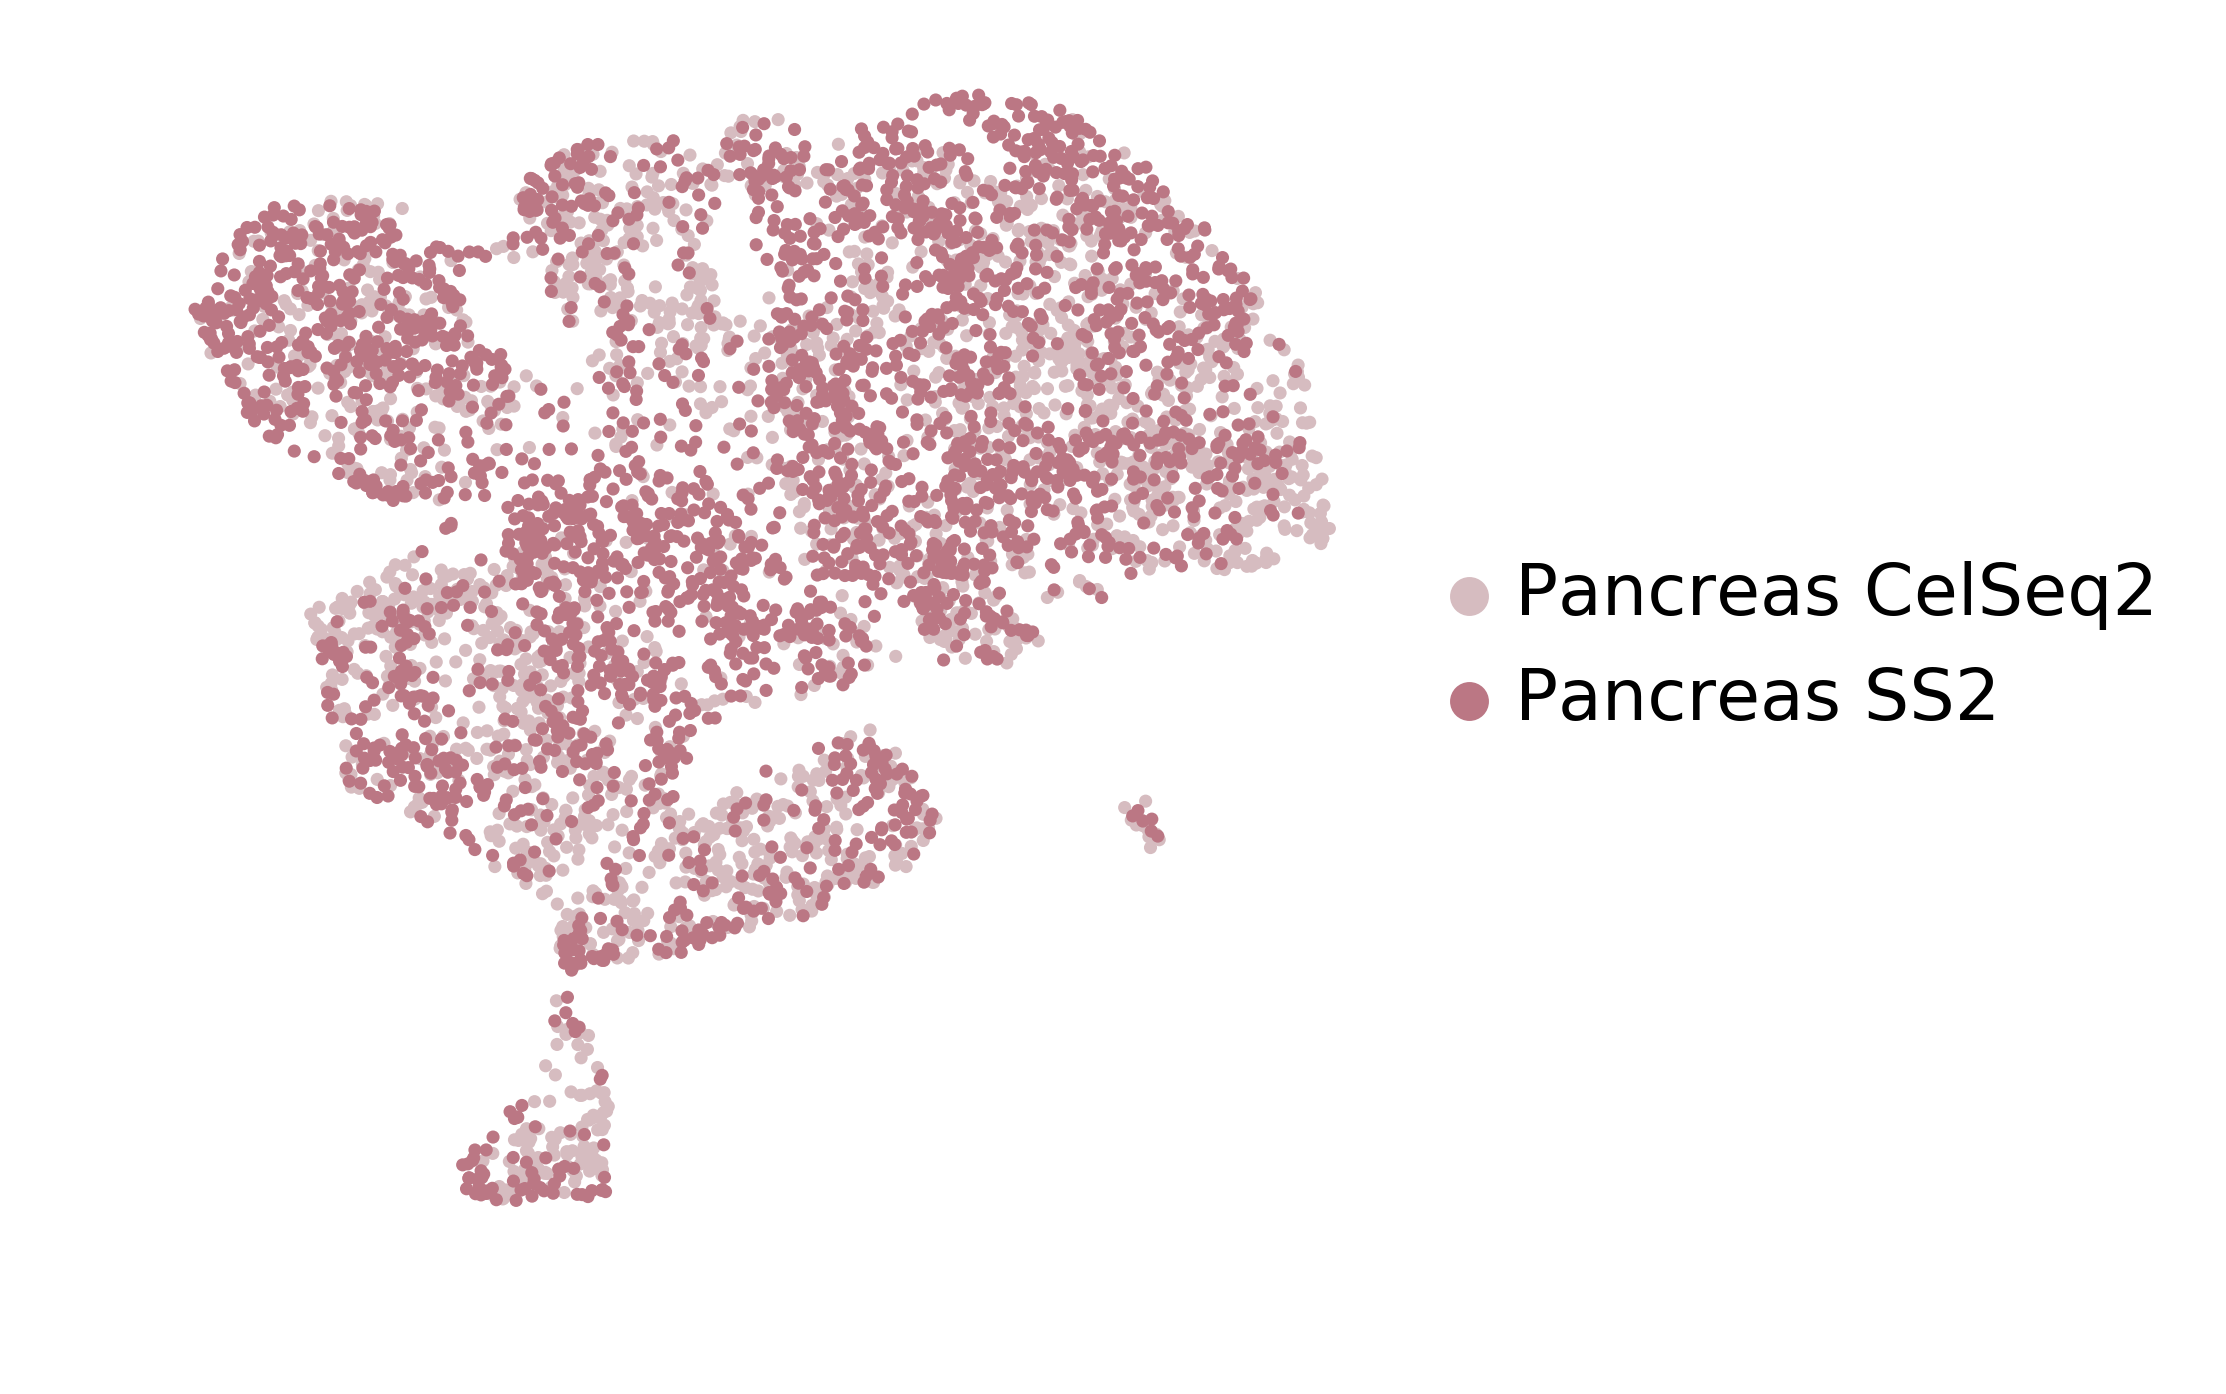

In [41]:
sc.pl.umap(latent_adata_after, color=[condition_key], frameon=False, title="", 
           save="_condition_out_of_sample_after.pdf", palette=sc.pl.palettes.zeileis_28[3:])

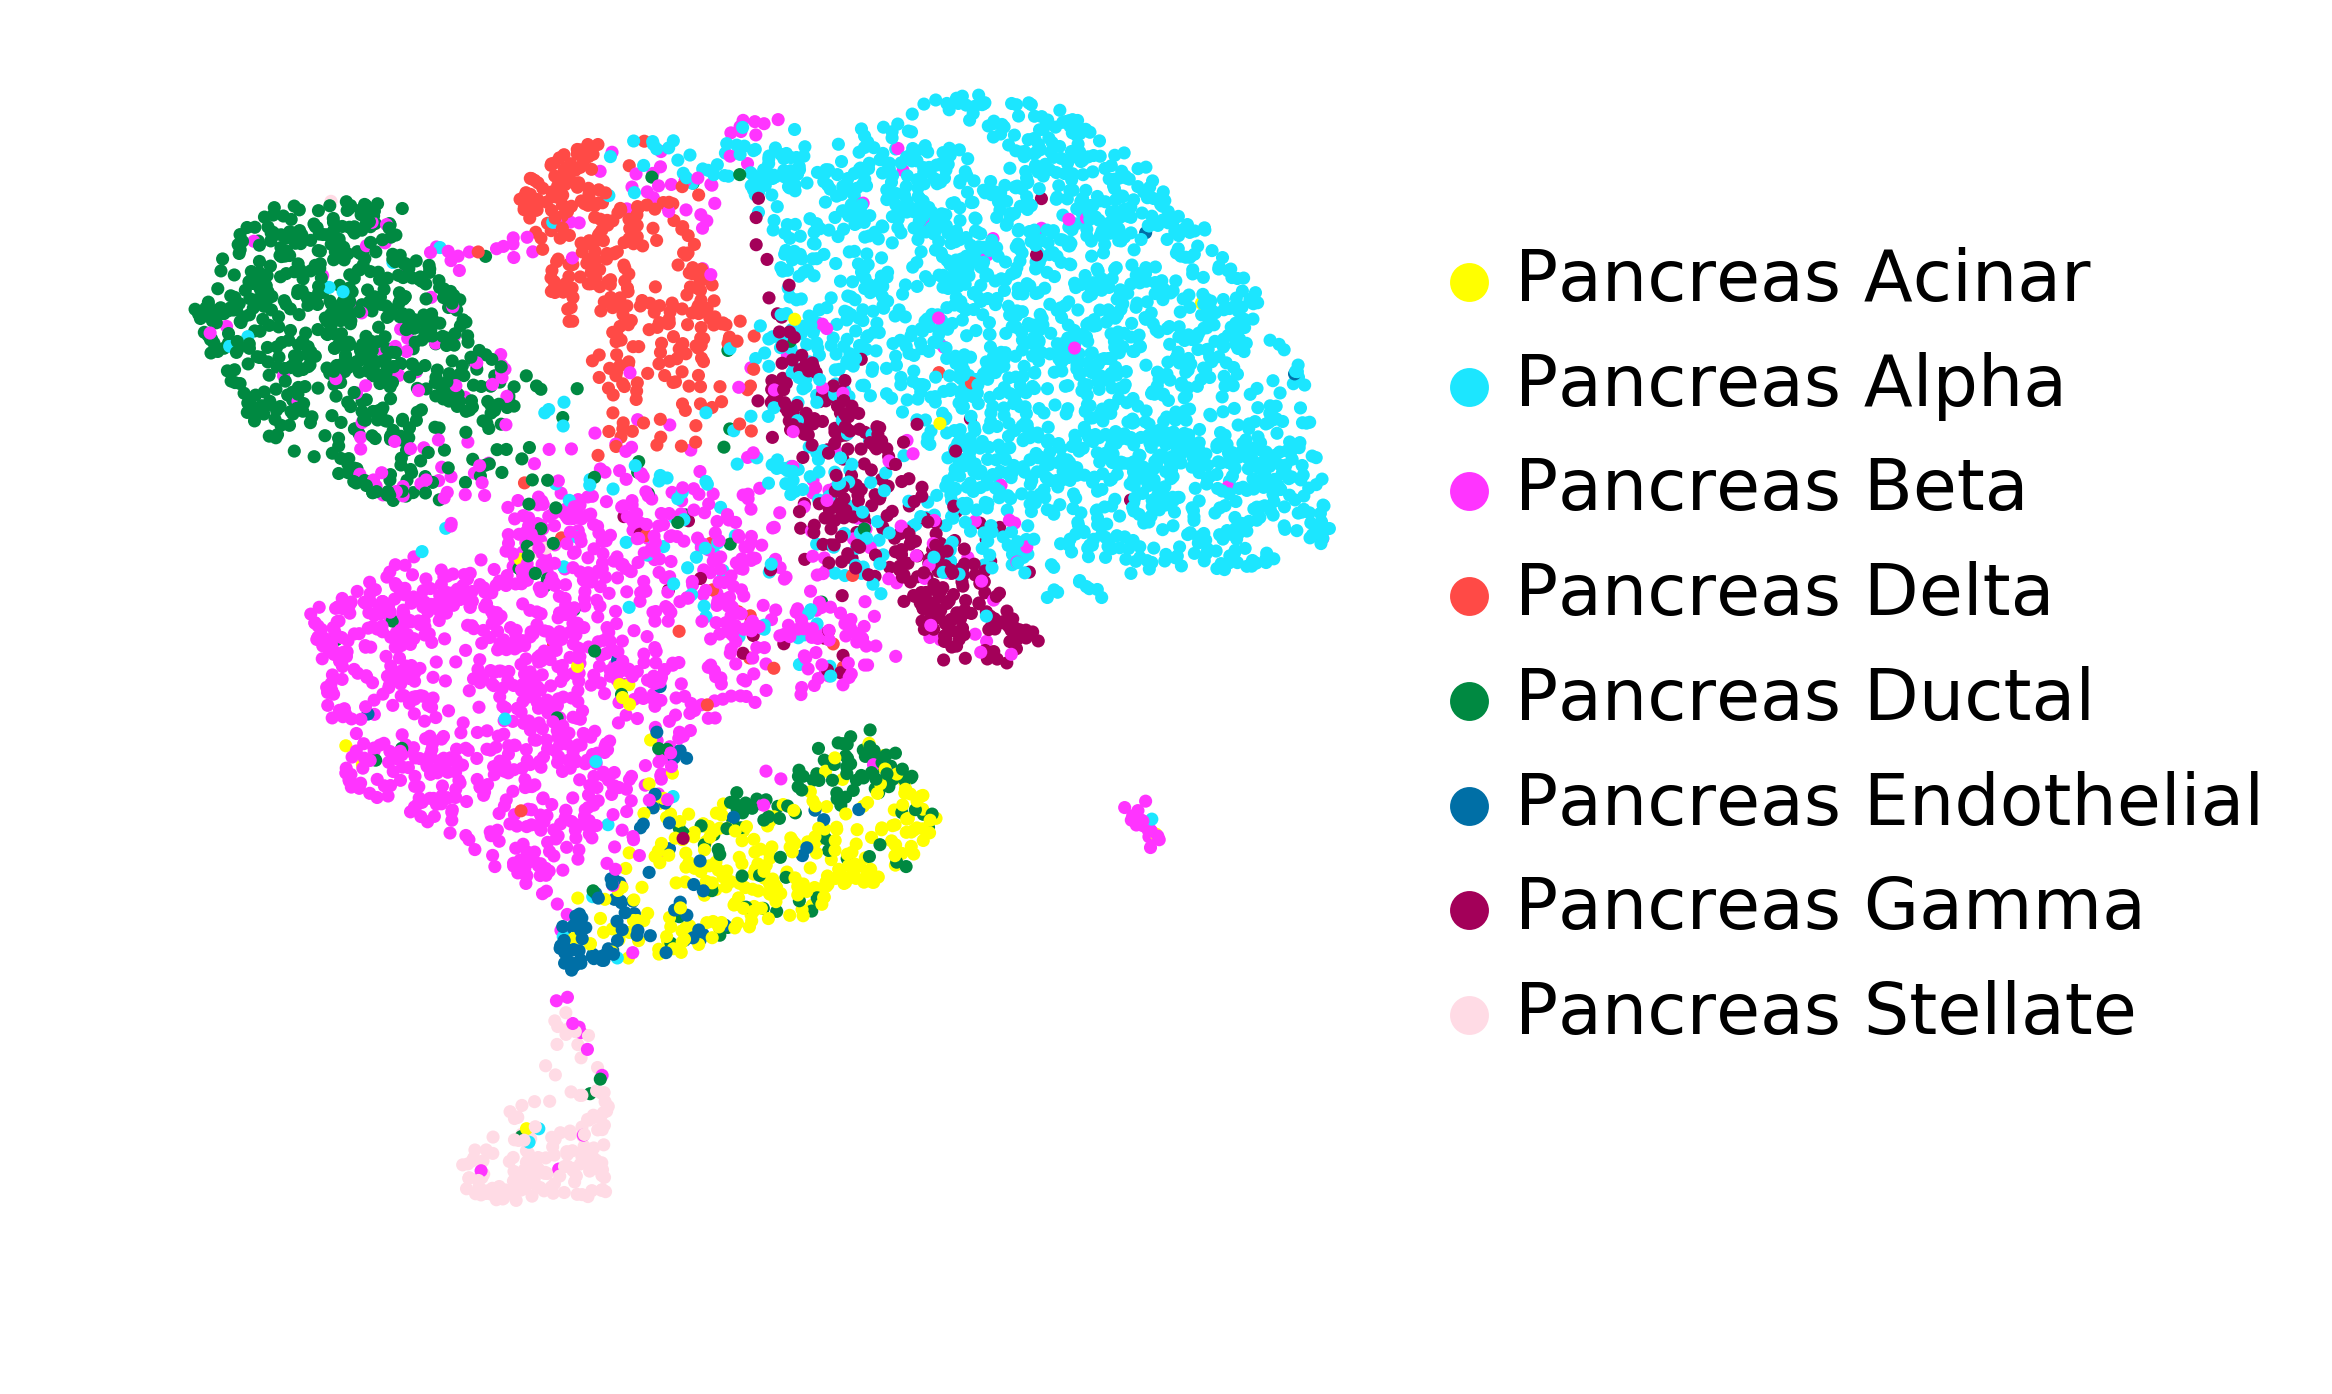

In [42]:
sc.pl.umap(latent_adata_after, color=[cell_type_key], frameon=False, title="", 
           save="_cell_type_out_of_sample_after.pdf", palette=sc.pl.palettes.godsnot_102)

# Let's see what has happened for the target cell type! :)

In [43]:
plot_adata = adata_for_training.concatenate(adata_out_of_sample)
plot_adata

AnnData object with n_obs × n_vars = 12971 × 1000 
    obs: 'batch', 'cell_type', 'size_factors', 'study'

In [44]:
encoder_labels, _ = surgeon.utils.label_encoder(plot_adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)
encoder_labels.shape

(12971, 1)

In [45]:
plot_adata.obs[cell_type_key].value_counts()

Pancreas Beta           5085
Pancreas Ductal         2104
Pancreas Alpha          1994
Pancreas Delta          1041
Pancreas Endothelial     836
Pancreas Acinar          713
Pancreas Gamma           637
Pancreas Stellate        561
Name: cell_type, dtype: int64

In [46]:
latent_adata = new_network.to_mmd_layer(plot_adata, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 12971 × 32 
    obs: 'batch', 'cell_type', 'size_factors', 'study'

In [47]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

... storing 'cell_type' as categorical
... storing 'study' as categorical


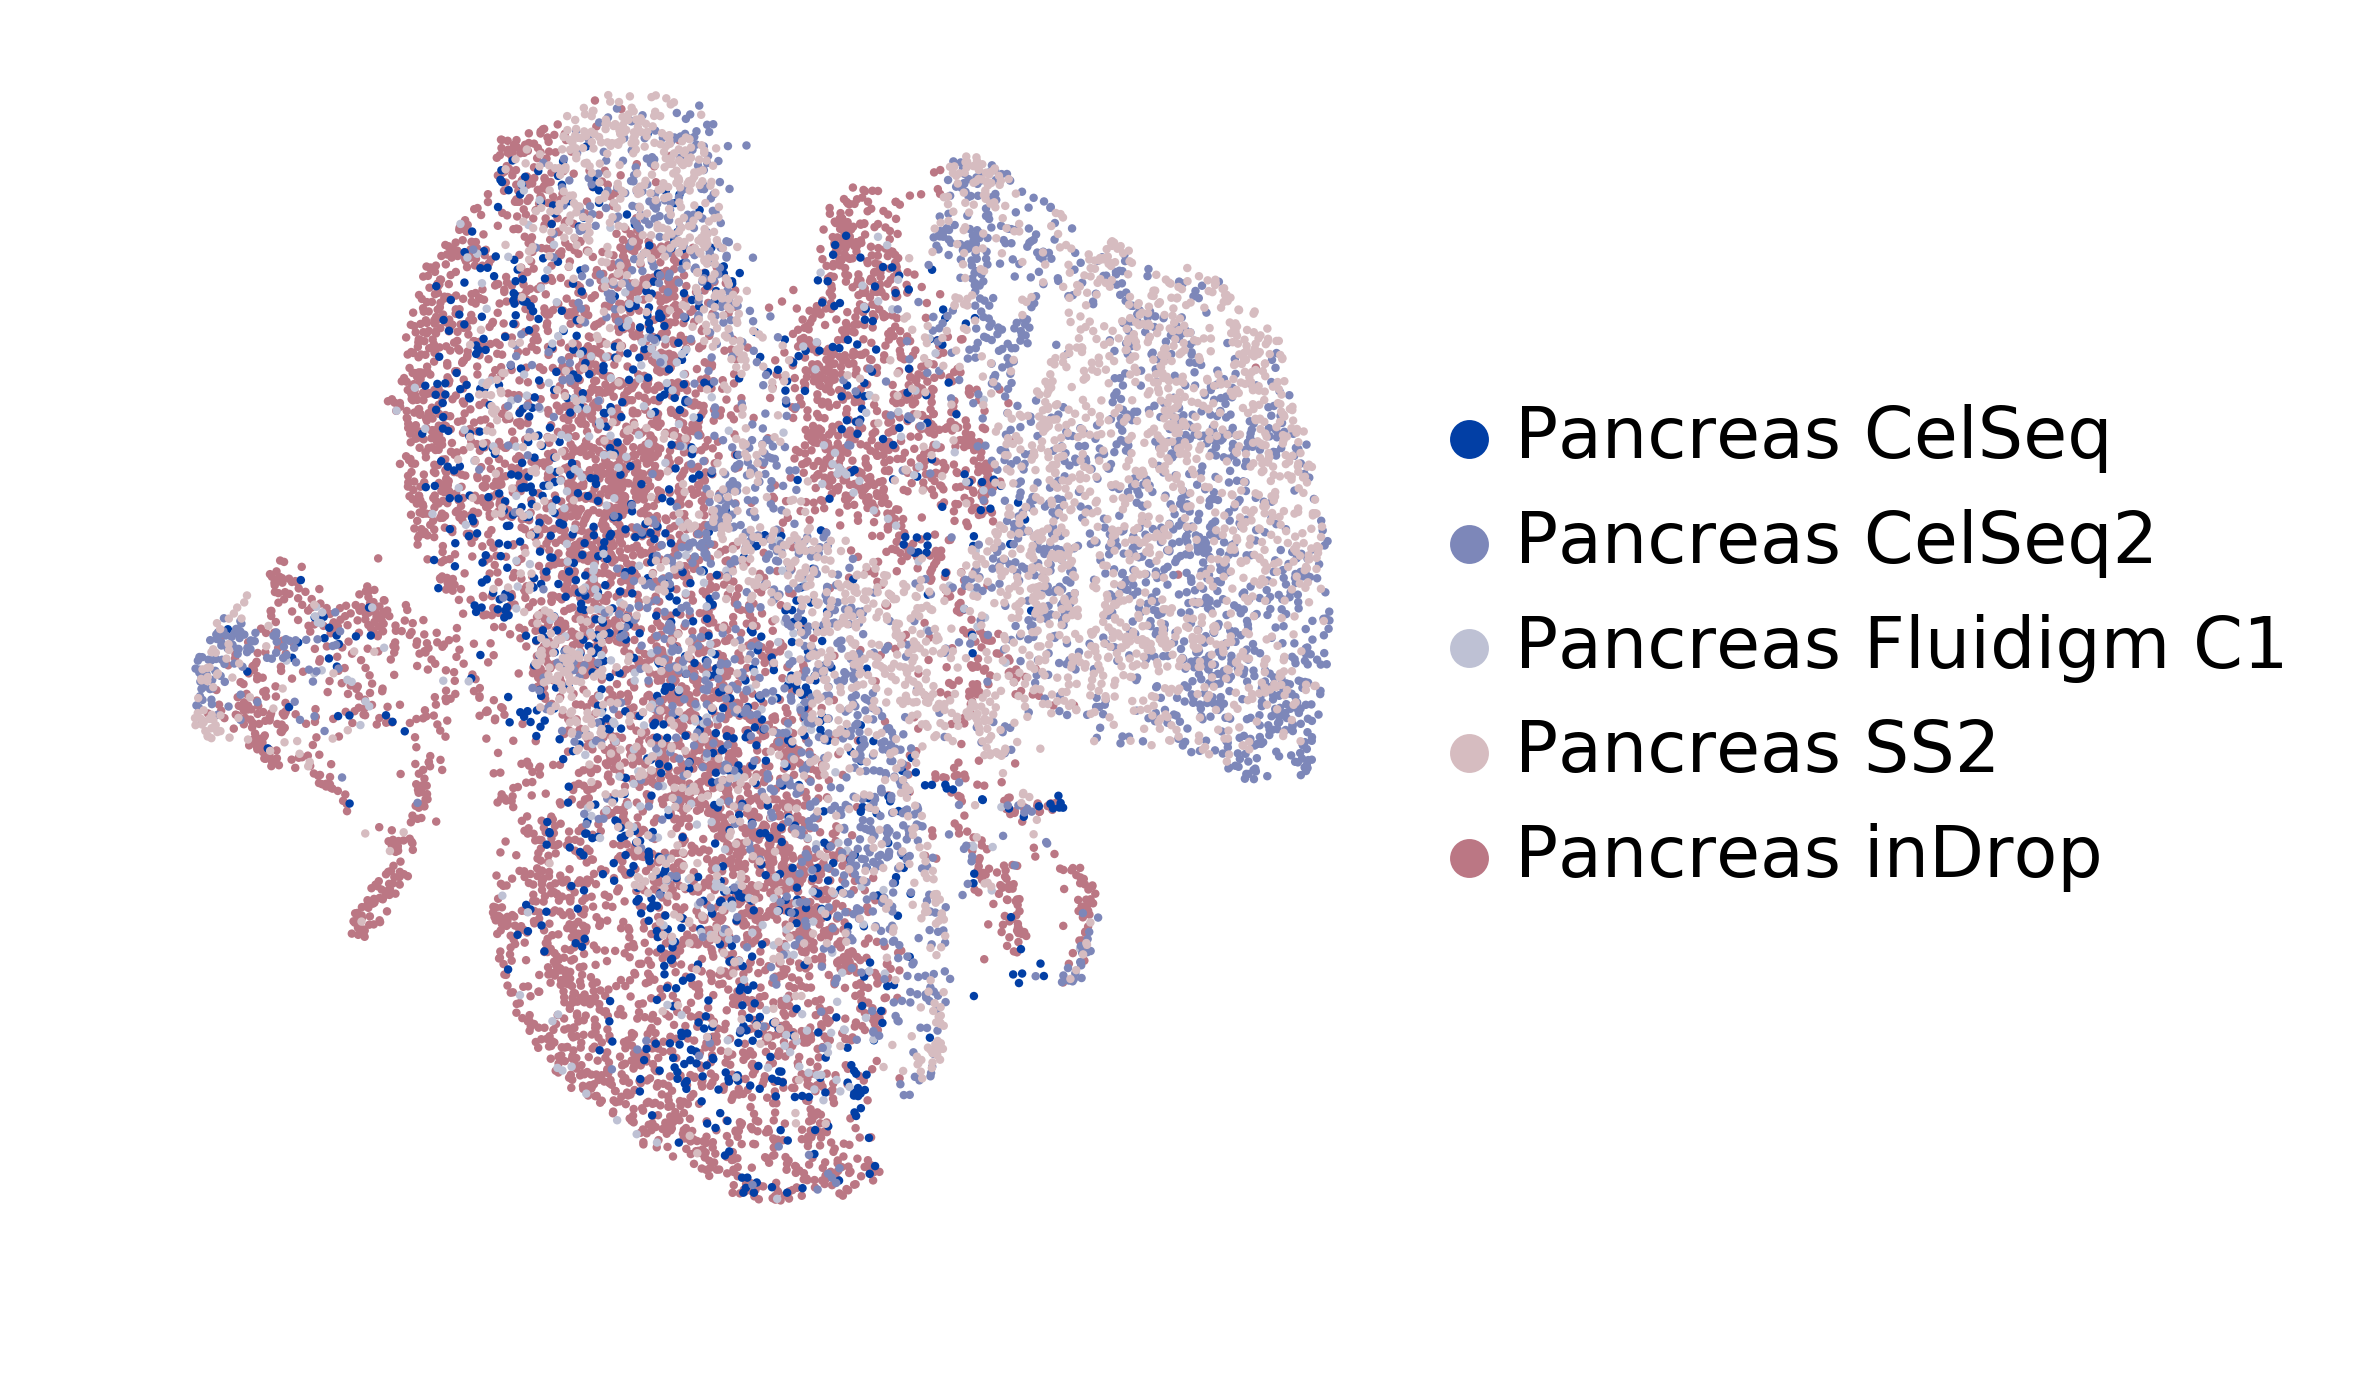

In [48]:
sc.pl.umap(latent_adata, color=[condition_key], frameon=False, title="", 
           save="_condition_all_after.pdf", palette=sc.pl.palettes.zeileis_28)

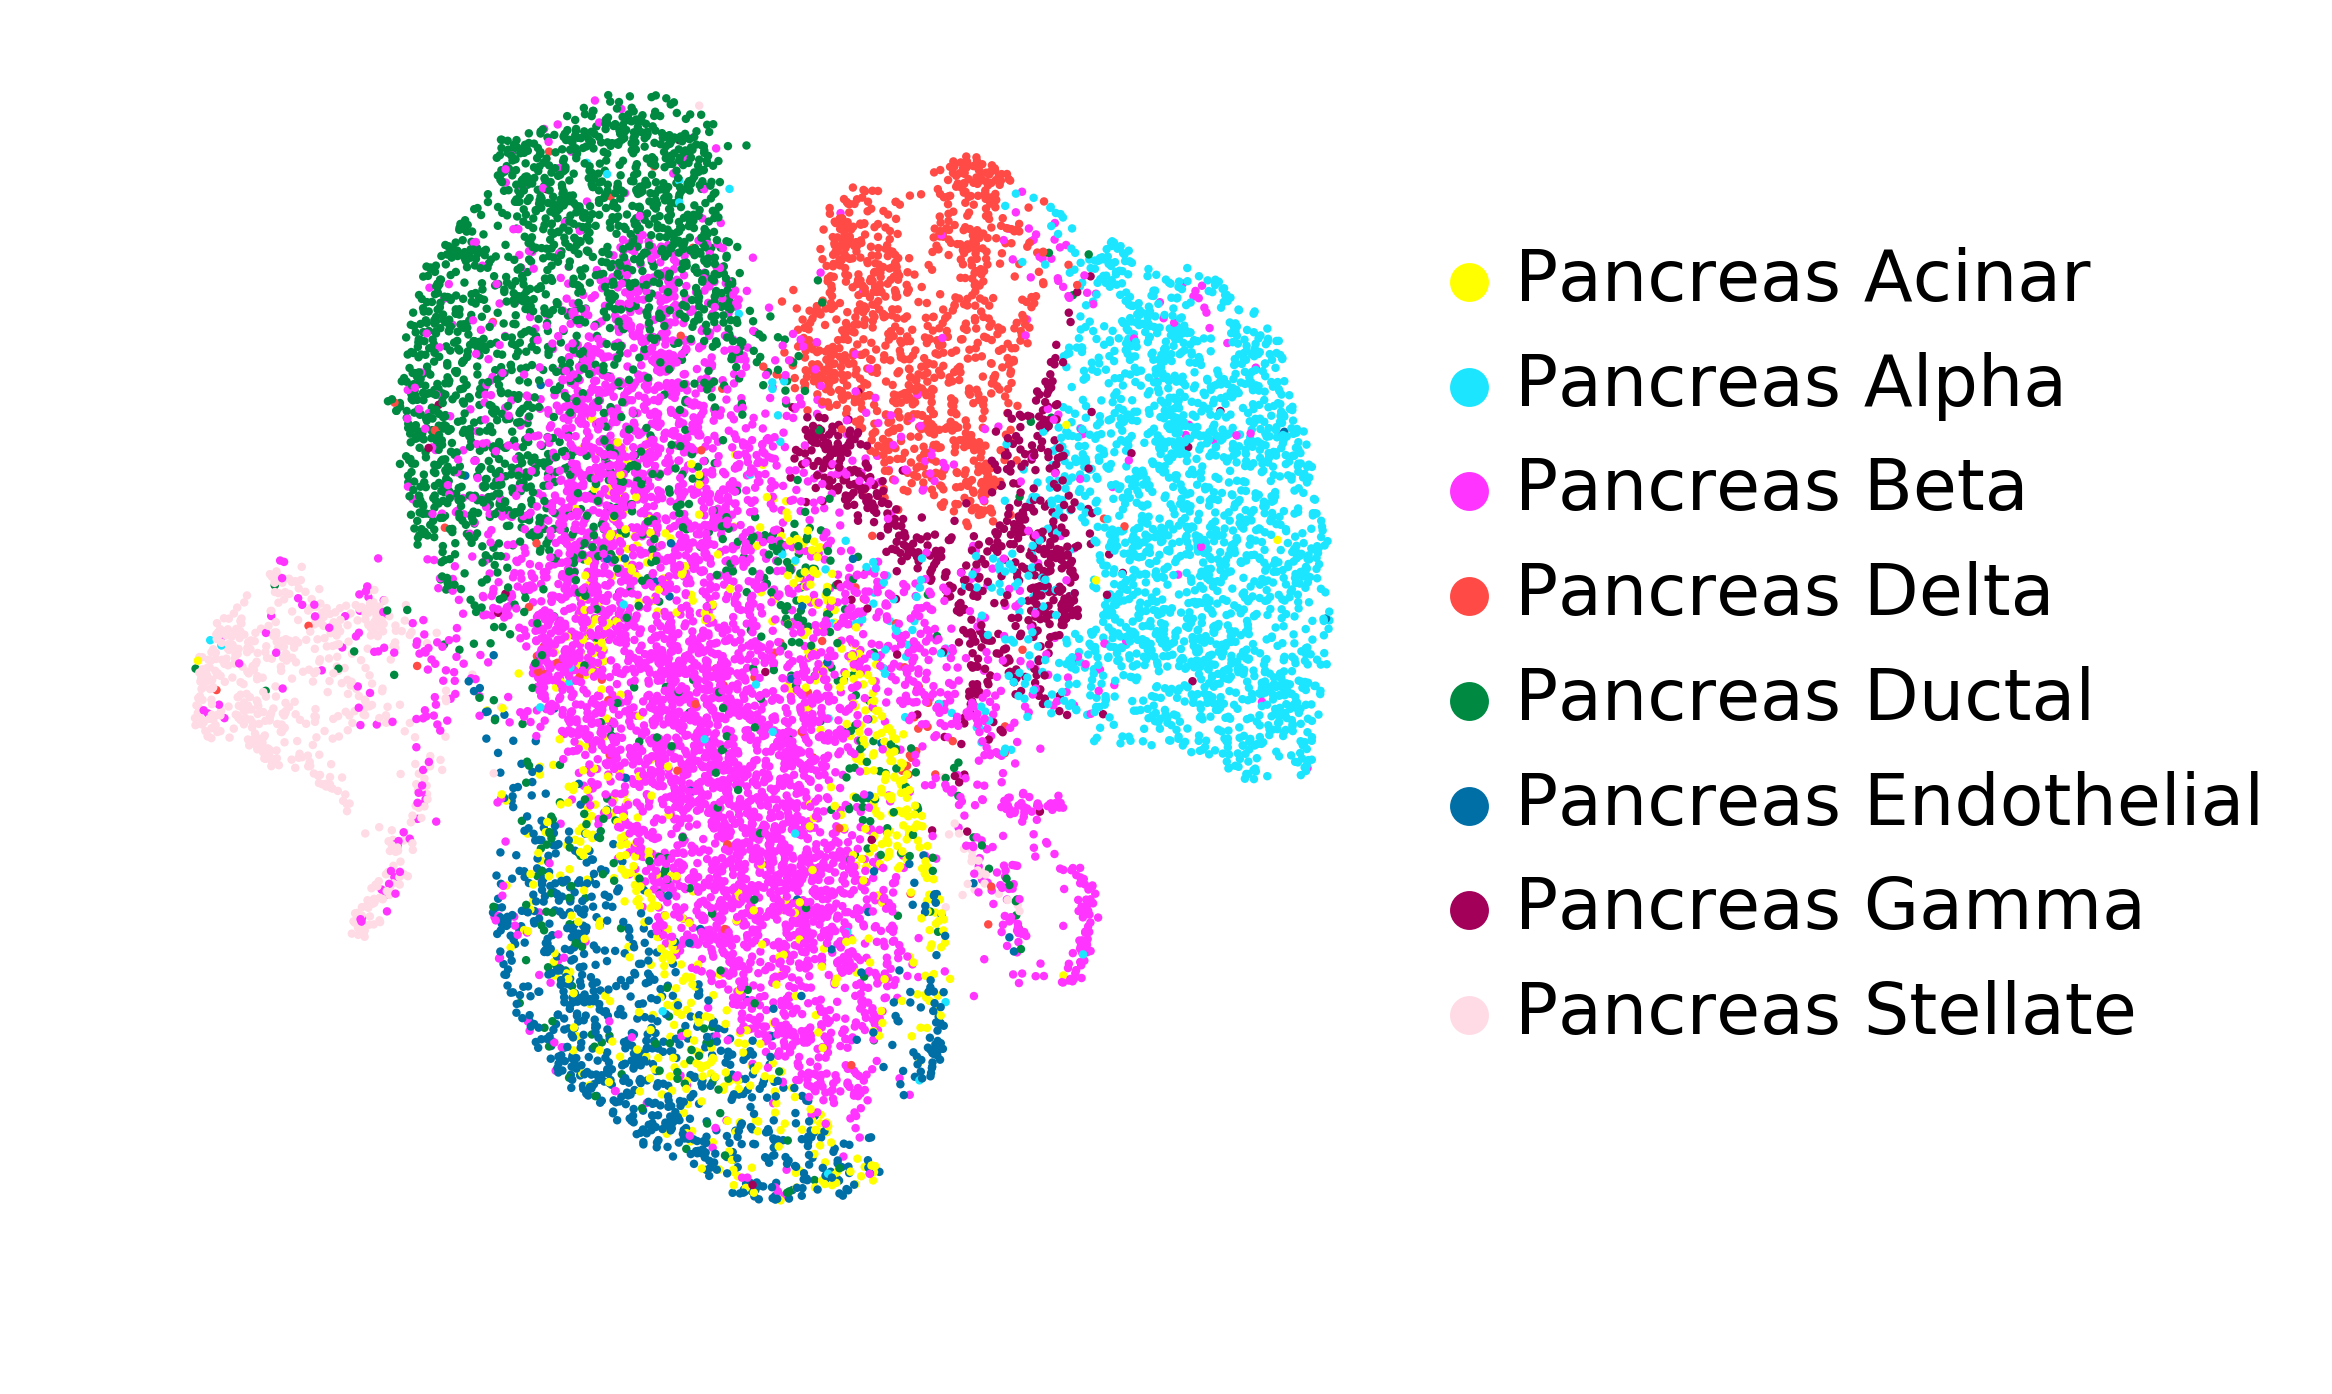

In [49]:
sc.pl.umap(latent_adata, color=[cell_type_key], frameon=False, title="", 
           save="_cell_type_all_after.pdf", palette=sc.pl.palettes.godsnot_102)